# Прогнозирование коэффициента восстановления золота

# Описание проекта

Необходимо сделать прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из руд. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель нужна для оптимизации параметров производства, чтобы не запускать предприятие с убыточными характеристиками.

# 1. Подготовка данных

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler

In [2]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

gold_train.info()
gold_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [3]:
gold_test.info()
gold_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [4]:
gold_full.info()
gold_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Проверка расчёта эффективности обогащения

Для проверки избавимся от пропусков в столбцах, используемых для расчёта эффективности обогащения

In [5]:
gold_train_temp = gold_train.dropna(axis='index', how='any', subset=['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']).copy()

In [6]:
gold_train_temp['recovery'] = (
    (gold_train_temp['rougher.output.concentrate_au'] * (
        gold_train_temp['rougher.input.feed_au'] - gold_train_temp['rougher.output.tail_au'])) / 
    (gold_train_temp['rougher.input.feed_au'] * (
        gold_train_temp['rougher.output.concentrate_au'] - gold_train_temp['rougher.output.tail_au']))
    ) *100

mean_squared_error(gold_train_temp['rougher.output.recovery'], gold_train_temp['recovery'])

2.0435431534920925e-28

Среднеквадратичная ошибка практически равна нулю (думаю, не идеальная точность обусловлена округлением), значит метрика расчитана верно

### Признаки, отсутствующие в тестовой выборке

In [7]:
missing_list = []
for i in range(len(gold_train.columns)):
    if gold_train.columns[i] not in gold_test.columns:
        missing_list.append(gold_train.columns[i])
        
missing_list

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Все эти признаки отражают содержание металлов на разных этапах процесса и расчётные метрики на их основе. Оперативно получать эти данные невозможно, ибо необходимо проведение лабораторных анализов (в лучшем случае результаты получают на следующие сутки). Следовательно мы не можем использовать эти признаки для обучения модели.  

Также в тестовой выборке отсутствуют целевые признаки, добавим их из полного датасета

In [8]:
gold_test = gold_test.merge(gold_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')

### Предобработка

##### Проверка дубликатов

In [9]:
print(gold_train.duplicated().sum())
print(gold_test.duplicated().sum())
print(gold_full.duplicated().sum())

0
0
0


##### Устранение ошибочных и выбивающихся значений

In [10]:
features_list = ['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
        'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']
for column in features_list:
    q1 = gold_train[column].quantile(0.25)
    q3 = gold_train[column].quantile(0.75)
    iqr = q3 -q1
    for i in range(len(gold_train)):
        if gold_train.loc[i,column] <= (q1 - 2 * iqr):
            gold_train.loc[i,column] = pd.np.nan
        if gold_train.loc[i,column] >= (q3 + 3 * iqr):
            gold_train.loc[i,column] = pd.np.nan           

    q1 = gold_test[column].quantile(0.25)
    q3 = gold_test[column].quantile(0.75)
    iqr = q3 -q1
    for i in range(len(gold_test)):
        if gold_test.loc[i,column] <= (q1 - 3 * iqr):
            gold_test.loc[i,column] = pd.np.nan
        if gold_test.loc[i,column] >= (q3 + 3 * iqr):
            gold_test.loc[i,column] = pd.np.nan

#####  Обработка пропусков и разделение данных

Посмотрим, возможно ли рассчитать пропущенные значения в ***'rougher.output.recovery'***

In [11]:
# Функция расчёта Recovery
def calc_rougher_recovery(row):
    try:
        # Рассчитываем Recovery только в случае отсутствия значения
        if np.isnan(row['rougher.output.recovery']) == True:
            recovery = (
                (row['rougher.output.concentrate_au'] * (
                    row['rougher.input.feed_au'] - row['rougher.output.tail_au'])) / 
                (row['rougher.input.feed_au'] * (
                    row['rougher.output.concentrate_au'] - row['rougher.output.tail_au']))) *100
            # Проверка на адекватность: Recovery может меняться в пределах от 0 до 100
            if 0 <= recovery <= 100:
                return recovery
            return pd.np.nan
        return row['rougher.output.recovery']
    except:
        return pd.np.nan

In [12]:
gold_full['rougher.output.recovery'].isna().sum()

3119

In [13]:
gold_full['rougher_recovery'] = gold_full.apply(calc_rougher_recovery, axis=1)
gold_full['rougher_recovery'].isna().sum()

3119

Количество пропущенных значений не изменилось. Часть значений невозможно рассчитать ввиду отсутствия одного из параметров, часть значений выходит за пределы интервала (0, 100). Те значения, которые выбиваются по величине мы не будем использовать потому что они однозначно ошибочны (есть множество факторов, которые могут привести к такому результату, например неверно проведённый анализ содержаний).

Сейчас разделим данные на датасеты, которые будем использовать для построения моделей

Первая модель будет предсказывать ***'rougher.output.recovery'***. Признаками будут служить только параметры, относящиеся к первому этапу флотации.

In [15]:
rougher_list = ['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level', 'rougher.output.recovery']

rougher_train = gold_train[rougher_list].copy()
rougher_test = gold_test[rougher_list].copy()

Вторая модель будет предсказывать ***'final.output.recovery'***. К признакам флотации добавим признаки, относящиеся к этапам очистки.

In [16]:
final_list = ['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
        'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level', 'final.output.recovery']

final_train = gold_train[final_list].copy()
final_test = gold_test[final_list].copy()

Заполнение пропусков в целевых признаках считаю нецелесообразным, поэтому избавлюсь от этих строк

In [17]:
rougher_train.dropna(subset=['rougher.output.recovery'], inplace=True)
rougher_test.dropna(subset=['rougher.output.recovery'], inplace=True)

final_train.dropna(subset=['final.output.recovery'], inplace=True)
final_test.dropna(subset=['final.output.recovery'], inplace=True)

Пропуски в остальных столбцах заполним предыдущим известным значением. Поскольку данные записываются каждый час, то у нас не должно быть резких сильных изменений в значениях

In [18]:
rougher_train.fillna(method='ffill', inplace=True)
rougher_test.fillna(method='ffill', inplace=True)

final_train.fillna(method='ffill', inplace=True)
final_test.fillna(method='ffill', inplace=True)

In [19]:
rougher_train = rougher_train.dropna(axis='index', how='any', subset=rougher_list).copy()
rougher_test = rougher_test.dropna(axis='index', how='any', subset=rougher_list).copy()

final_train = final_train.dropna(axis='index', how='any', subset=final_list).copy()
final_test = final_test.dropna(axis='index', how='any', subset=final_list).copy()

Разделим данные на целевые и изучаемые признаки

In [20]:
features_rougher_train = rougher_train.drop(['rougher.output.recovery'], axis=1)
features_rougher_test = rougher_test.drop(['rougher.output.recovery'], axis=1)
target_rougher_train = rougher_train['rougher.output.recovery']
target_rougher_test = rougher_test['rougher.output.recovery']

features_final_train = final_train.drop(['final.output.recovery'], axis=1)
features_final_test = final_test.drop(['final.output.recovery'], axis=1)
target_final_train = final_train['final.output.recovery']
target_final_test = final_test['final.output.recovery']

##### Масштабирование данных

In [21]:
rougher_list.remove('rougher.output.recovery')

scaler = StandardScaler()
scaler.fit(features_rougher_train[rougher_list])

scaled_rougher_train = features_rougher_train.copy()
scaled_rougher_test = features_rougher_test.copy()

scaled_rougher_train[rougher_list] = scaler.transform(features_rougher_train[rougher_list])
scaled_rougher_test[rougher_list] = scaler.transform(features_rougher_test[rougher_list])


final_list.remove('final.output.recovery')
scaler.fit(features_final_train[final_list])

scaled_final_train = features_final_train.copy()
scaled_final_test = features_final_test.copy()

scaled_final_train[final_list] = scaler.transform(features_final_train[final_list])
scaled_final_test[final_list] = scaler.transform(features_final_test[final_list])

# 2. Анализ данных

##### Концентрация металлов на разных этапах

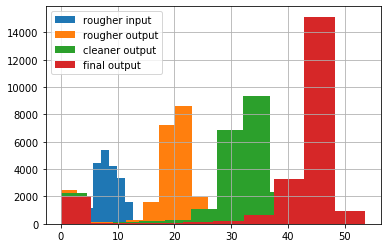

In [22]:
gold_full['rougher.input.feed_au'].hist(label='rougher input')
gold_full['rougher.output.concentrate_au'].hist(label='rougher output')
gold_full['primary_cleaner.output.concentrate_au'].hist(label='cleaner output')
gold_full['final.output.concentrate_au'].hist(label='final output')
plt.legend()

С каждым этапом концентрация золота растёт, собственно ради этого всё и затевалось

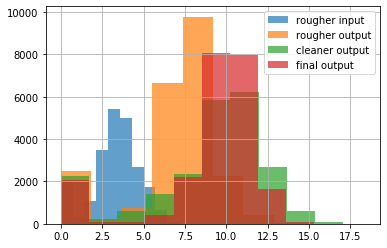

In [23]:
gold_full['rougher.input.feed_pb'].hist(label='rougher input', alpha=0.7)
gold_full['rougher.output.concentrate_pb'].hist(label='rougher output', alpha=0.7)
gold_full['primary_cleaner.output.concentrate_pb'].hist(label='cleaner output', alpha=0.7)
gold_full['final.output.concentrate_pb'].hist(label='final output', alpha=0.7)
plt.legend()

Сначала концентрация свинца растёт, но на последнем этапе очистки чуть-чуть снижается.

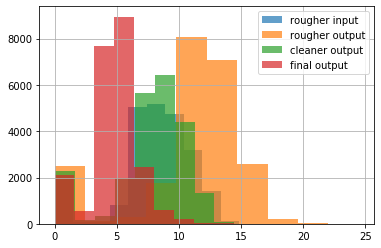

In [24]:
gold_full['rougher.input.feed_ag'].hist(label='rougher input', alpha=0.7)
gold_full['rougher.output.concentrate_ag'].hist(label='rougher output', alpha=0.7)
gold_full['primary_cleaner.output.concentrate_ag'].hist(label='cleaner output', alpha=0.7)
gold_full['final.output.concentrate_ag'].hist(label='final output', alpha=0.7)
plt.legend()

На этапе флотации концентрация серебра растёт, затем после двух этапов очистки заметно снижается.

В итоге у нас получается концентрат с повышенным содержанием золота. Тем не менее это ещё не конечный продукт. В последствии финальный концентрат будет переплавляться и будет производится очистка золота.

##### Сравнение размеров частиц

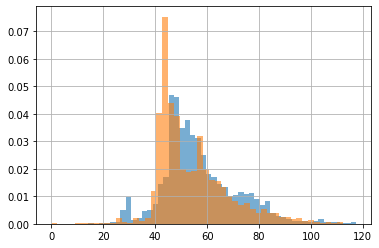

In [25]:
gold_train['rougher.input.feed_size'].hist(bins=50, density=True, alpha=0.6, label='train')
gold_test['rougher.input.feed_size'].hist(bins=50, density=True, alpha=0.6, label='test')

Размер частиц одинаковый, значит можем предсказывать целевые признаки в тестовой выборке моделью обученной на тренировочной.

##### Суммарная концентрация веществ

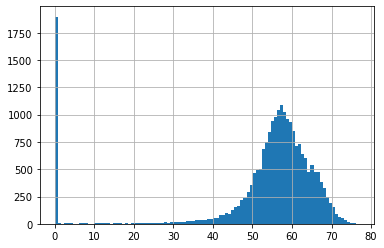

In [26]:
gold_full['concentration'] = gold_full['rougher.input.feed_au'] + gold_full['rougher.input.feed_ag'] + gold_full['rougher.input.feed_pb'] + gold_full['rougher.input.feed_sol']
gold_full['concentration'].hist(bins=100)

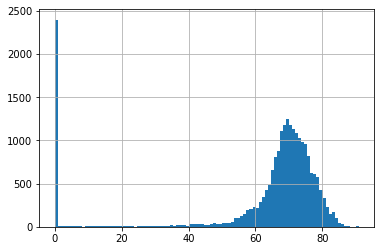

In [27]:
gold_full['concentration'] = gold_full['rougher.output.concentrate_au'] + gold_full['rougher.output.concentrate_ag'] + gold_full['rougher.output.concentrate_pb'] + gold_full['rougher.output.concentrate_sol']
gold_full['concentration'].hist(bins=100)

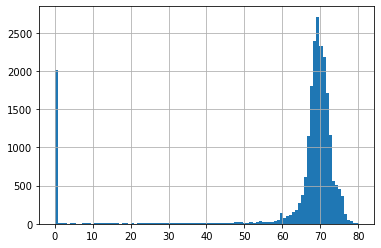

In [28]:
gold_full['concentration'] = gold_full['final.output.concentrate_au'] + gold_full['final.output.concentrate_ag'] + gold_full['final.output.concentrate_pb'] + gold_full['final.output.concentrate_sol']
gold_full['concentration'].hist(bins=100)

Имеем большое количество околонулевых значений, скорее всего это ошибочные значения. От них мы избавились на этапе подготовки данных.

# 3. Модель

In [33]:
def smape(target, prediction):
    return ((abs(target - prediction) / ((abs(target) - abs(prediction)) / 2)) * 100).mean() #.sum() / len(target)

smape_scorer = make_scorer(smape, greater_is_better=False)

##### Линейная регрессия

In [34]:
smape_scorer = make_scorer(smape, greater_is_better=True)
model_lr = LinearRegression()

scores_rougher = cross_val_score(model_lr, scaled_rougher_train, target_rougher_train, scoring=smape_scorer, cv=5)
scores_final = cross_val_score(model_lr, scaled_final_train, target_final_train, scoring=smape_scorer, cv=5)
final_score = 0.25 * (sum(scores_rougher) / len(scores_rougher)) + 0.75 * (sum(scores_final) / len(scores_final))
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 1.8777657380585975


##### Случайный лес

In [40]:
smape_scorer = make_scorer(smape, greater_is_better=False)
model_rfr = RandomForestRegressor(random_state=42)

grid_param = {'n_estimators' : [50 * x for x in range(1, 6)],
              'max_depth' : [5 * x for x in range(1, 11)]}

grid_search = GridSearchCV(model_rfr, grid_param, scoring=smape_scorer, n_jobs=-1, cv=3)
grid_search.fit(scaled_rougher_train, target_rougher_train)
grid_search.best_params_

**Примечание:** пришлось запустить gridsearch на своём компьютере. Результат:  
{'max_depth': 5, 'n_estimators': 200}

##### Тестирование модели

In [35]:
model_lr.fit(scaled_rougher_train, target_rougher_train)
predicted_test = pd.Series(model_lr.predict(scaled_rougher_test))

smape_rougher = smape(target_rougher_test, predicted_test)

model_lr.fit(scaled_final_train, target_final_train)
predicted_test = pd.Series(model_lr.predict(scaled_final_test))

smape_final = smape(target_final_test, predicted_test)

final_smape = 0.25 * smape_rougher + 0.75 * smape_final
final_smape

8.164872382620342

In [38]:
model_rfr = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
model_rfr.fit(scaled_rougher_train, target_rougher_train)
predicted_test = pd.Series(model_rfr.predict(scaled_rougher_test))

smape_rougher = smape(target_rougher_test, predicted_test)

model_rfr.fit(scaled_final_train, target_final_train)
predicted_test = pd.Series(model_rfr.predict(scaled_final_test))

smape_final = smape(target_final_test, predicted_test)

smape_last = 0.25 * smape_rougher + 0.75 * smape_final
smape_last


19.247654455991512

##### Константная модель

In [38]:
rougher_median = pd.Series(target_rougher_train.median(), index = target_rougher_test.index)
final_median = pd.Series(target_final_train.median(), index = target_final_test.index)
smape_rougher = smape(target_rougher_test, rougher_median)
smape_final = smape(target_final_test, final_median)
smape_last = 0.25 * smape_rougher + 0.75 * smape_final
smape_last

62.188540128719126

# Итоги

+ В исходных данных присутствует много выбросов и пропусков, без их обработки качество моделей получиться весьма низкое
+ Лучшие результаты показала линейная регрессия
+ Обе проверенные модели показали результат лучше, чем константная модель